In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import darts
from darts import TimeSeries

In [17]:
df = pd.DataFrame(
    data={
        "dates": [
            "2020-01-01",
            "2020-01-02",
            "2020-01-03",
            "2020-01-01",
            "2020-01-02",
            "2020-01-03",
        ],
        "comp1": np.random.random((6,)),
        "comp2": np.random.random((6,)),
        "comp3": np.random.random((6,)),
        "ID": ["SERIES1", "SERIES1", "SERIES1", "SERIES2", "SERIES2", "SERIES2"],
        "var1": [0.5, 0.5, 0.5, 0.75, 0.75, 0.75],
    }
)
print("Input DataFrame")
print(df)
df = df.sort_values(["dates","ID"]) ### <==== Sorting df by time causes UserWarning to be raised

series_multi = TimeSeries.from_group_dataframe(
    df,
    time_col="dates",
    group_cols="ID",  # individual time series are extracted by grouping `df` by `group_cols`
    static_cols=[
        "var1"
    ],  # also extract these additional columns as static covariates (without grouping)
    value_cols=[
        "comp1",
        "comp2",
        "comp3",
    ],  # optionally, specify the time varying columns
)

Input DataFrame
        dates     comp1     comp2     comp3       ID  var1
0  2020-01-01  0.264440  0.170513  0.747708  SERIES1  0.50
1  2020-01-02  0.220937  0.155634  0.805595  SERIES1  0.50
2  2020-01-03  0.140140  0.664718  0.481642  SERIES1  0.50
3  2020-01-01  0.406470  0.876687  0.591737  SERIES2  0.75
4  2020-01-02  0.438746  0.661515  0.922524  SERIES2  0.75
5  2020-01-03  0.779997  0.533622  0.199281  SERIES2  0.75


In [12]:
df = pd.DataFrame(
    data={
        "dates": [
            "2020-01-01",
            "2020-01-02",
            "2020-01-03",
            "2020-01-04",
            "2020-01-05",
            "2020-01-06",
        ],
        "comp1": np.random.random((6,)),
        "ID": ["SERIES1", "SERIES1", "SERIES1", "SERIES1", "SERIES1", "SERIES1"]
    }
)

series_multi = TimeSeries.from_group_dataframe(
    df,
    time_col="dates",
    group_cols="ID", 
    value_cols=[
        "comp1"]
)

In [16]:
series_multi[0]

<TimeSeries (DataArray) (dates: 6, component: 1, sample: 1)> Size: 48B
array([[[0.88301184]],

       [[0.11627766]],

       [[0.28057258]],

       [[0.15477718]],

       [[0.78718982]],

       [[0.92749852]]])
Coordinates:
  * dates      (dates) datetime64[ns] 48B 2020-01-01 2020-01-02 ... 2020-01-06
  * component  (component) object 8B 'comp1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates       ID\ncomponent                ...
    hierarchy:          None

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def cprint(title, *args):
    print(
        "="*len(title), title, "="*len(title),
        *args,
        sep="\n",
    )

In [8]:
PATH = '.'

train = pd.read_csv(os.path.join(PATH, "train.csv"), parse_dates=["date"])
test = pd.read_csv(os.path.join(PATH, "test.csv"), parse_dates=["date"])

oil = pd.read_csv(os.path.join(PATH, "oil.csv"), parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
store = pd.read_csv(os.path.join(PATH, "stores.csv"))
transaction = pd.read_csv(os.path.join(PATH, "transactions.csv"), parse_dates=["date"])
holiday = pd.read_csv(os.path.join(PATH, "holidays_events.csv"), parse_dates=["date"])

In [9]:
num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_ts = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1

In [10]:
cprint(
    "Basic information of data",
    f"Number of family types      : {num_family}",
    f"Number of stores            : {num_store}",
    f"Number of store-family pairs: {num_family * num_store}",
    f"Number of target series     : {num_ts}",
    "",
    f"Number of unique train dates: {num_train_date}",
    f"Train date range            : {train_len} days from {train_start} to {train_end}",
    f"Number of unique test dates : {num_test_date}",
    f"Test date range             : {test_len} days from {test_start} to {test_end}",
)

Basic information of data
Number of family types      : 33
Number of stores            : 54
Number of store-family pairs: 1782
Number of target series     : 1782

Number of unique train dates: 1684
Train date range            : 1688 days from 2013-01-01 to 2017-08-15
Number of unique test dates : 16
Test date range             : 16 days from 2017-08-16 to 2017-08-31


In [11]:
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

unique_dp_count = train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [12]:
cprint(
    "Missing gaps in time series",
    f"List incl. unique counts of data points: {unique_dp_count}",
    f"Missing dates                          : {missing_dates}",
)

Missing gaps in time series
List incl. unique counts of data points: [1684]
Missing dates                          : ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


In [13]:
# reindex training data
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

# fill missing values with 0s
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)
train.id = train.id.interpolate(method="linear") # interpolate linearly as a filler for the 'id'

In [14]:
missing_oil_dates = pd.date_range(train_start, test_end).difference(oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_wknd_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range(train_start, test_end).weekday >= 5).sum()

In [15]:
cprint(
    "Missing oil dates",
    f"Number of missing oil dates: {num_missing_oil_dates}",
    f"Number of weekends missing : {num_wknd_missing}",
    f"Total number of weekends   : {total_num_wknd}",
)

Missing oil dates
Number of missing oil dates: 486
Number of weekends missing : 486
Total number of weekends   : 486


In [16]:
# reindex oil data
oil = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
oil.oil = oil.oil.interpolate(method="linear", limit_direction="both")

In [17]:
num_zero_sales = (train.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_rec = num_store * train_len
curr_rec = len(transaction.index)
missing_rec = total_rec - curr_rec - num_zero_sales

In [18]:
cprint(
    "Missing transaction records",
    f"Correct number of records: {total_rec}",
    "",
    "Breakdown...",
    f"Current number of records: {curr_rec}",
    f"Number of zero sales     : {num_zero_sales}",
    f"Number of missing records: {missing_rec}",
)

Missing transaction records
Correct number of records: 91152

Breakdown...
Current number of records: 83488
Number of zero sales     : 7546
Number of missing records: 118


In [19]:
# compute total sales for each store
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
transaction = transaction.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# fill missing values with 0s for days with zero sales
transaction.loc[transaction.sales.eq(0), "transactions"] = 0.
transaction = transaction.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
transaction.transactions = transaction.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

In [20]:
national_locale_name = sorted(holiday[holiday.locale.eq("National")].locale_name.unique().tolist())
regional_locale_name = sorted(holiday[holiday.locale.eq("Regional")].locale_name.unique().tolist())
local_locale_name = sorted(holiday[holiday.locale.eq("Local")].locale_name.unique().tolist())

In [21]:
cprint(
    "List of locale names for each holiday",
    "Locale names for national holidays:",
    national_locale_name,
    "",
    "Locale names for regional holidays:",
    regional_locale_name,
    "",
    "Locale names for local holidays:",
    local_locale_name,
)

List of locale names for each holiday
Locale names for national holidays:
['Ecuador']

Locale names for regional holidays:
['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']

Locale names for local holidays:
['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


In [22]:
holiday[(holiday.description.str.contains("Navidad"))&(holiday.date.dt.year.eq(2012))]

,date,type,locale,locale_name,description,transferred
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False


In [23]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(store.city.str.lower()) | set(store.state.str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

In [24]:
holiday.description = holiday.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""), 
    axis=1,
).apply(
    process_holiday
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).str.strip()

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


In [25]:
# remove transferred holidays
holiday = holiday[holiday.transferred.eq(False)]

#########################################
### Saturdays designated as work days ###
#########################################
work_days = holiday[holiday.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)
# remove work days after extracting above
holiday = holiday[holiday.type!="Work Day"].reset_index(drop=True)

###################################
### local holidays (city level) ###
###################################
local_holidays = holiday[holiday.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

#######################################
### regional holidays (state level) ###
#######################################
regional_holidays = holiday[holiday.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

#########################
### national holidays ###
#########################
national_holidays = holiday[holiday.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [26]:
sales_ts = pd.pivot_table(train, values="sales", index="date", columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(transaction, values="transactions", index="date", columns="store_nbr")
promo_ts = pd.pivot_table(train, values="onpromotion", index="date", columns=["store_nbr", "family"])

sales_ts.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  

[5 rows x 1782 columns]

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
# scale target series
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

# convert back to long form and add the holiday columns
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,
).reset_index().merge(
    store, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    local_holidays, on=["date", "city"], how="left",
).merge(
    regional_holidays, on=["date", "state"], how="left",
).merge(
    national_holidays, on="date", how="left",
).fillna(0)

# include dummy variable for dates without any holidays
holiday_list = [col for col in holiday_sales_merged if col.startswith(("loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(axis=1).eq(0).astype(int)
holiday_sales_merged.head()


,date,store_nbr,family,sales,city,state,type,cluster,work_day,loc_cantonizacion,...,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0.000000,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,2013-01-02,1,AUTOMOTIVE,0.105263,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2013-01-03,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2013-01-04,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2013-01-05,1,AUTOMOTIVE,0.263158,Quito,Pichincha,D,13,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [29]:
import seaborn as sns
COLORS = list(sns.color_palette())


Covariates: oil, onpromotion, transactions
Past covariates  : transactions
Future covariates: oil, onpromotion


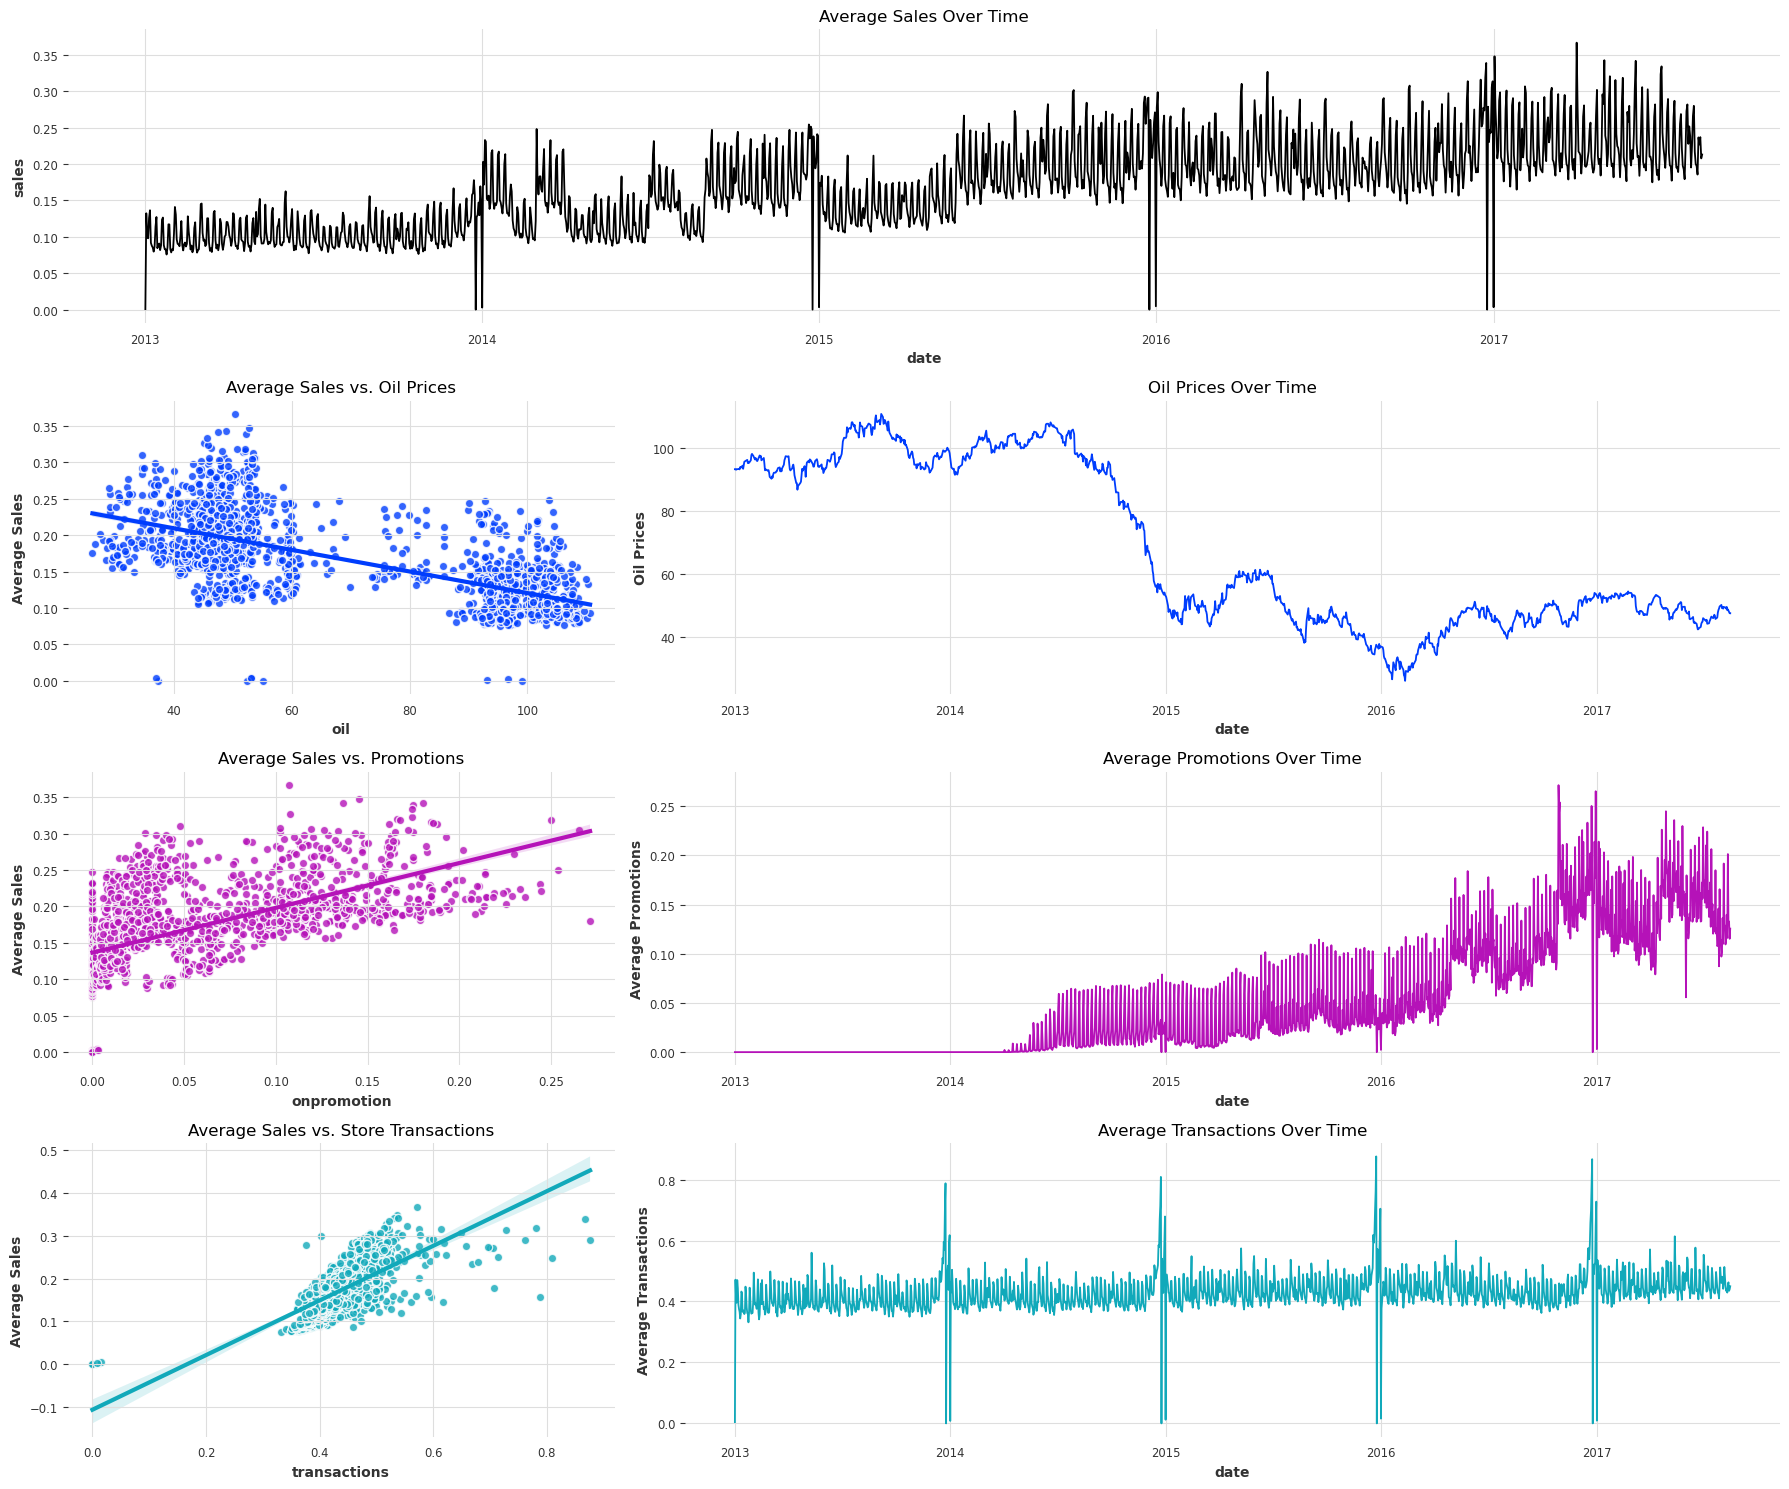

In [30]:
def plot_sales_correlation():   
    tr_ts_scaled = tr_ts.copy()
    tr_ts_scaled[tr_ts_scaled.columns] = scaler.fit_transform(tr_ts_scaled)

    promo_ts_scaled = promo_ts.copy()
    promo_ts_scaled[promo_ts_scaled.columns] = scaler.fit_transform(promo_ts_scaled)
    
    mean_sales_ts_scaled = sales_ts_scaled.mean(axis=1).to_frame("sales").reset_index()
    mean_promo_ts_scaled = promo_ts_scaled.mean(axis=1).to_frame("onpromotion").reset_index()
    mean_tr_ts_scaled = tr_ts_scaled.mean(axis=1).to_frame("transactions").reset_index()
    
    cprint( 
        "Covariates: oil, onpromotion, transactions",
        "Past covariates  : transactions",
        "Future covariates: oil, onpromotion",
    )

    plot_kwargs = {
        "scatter_kws": {"edgecolor": "white"},
        "line_kws": {"lw": 3},
    }
    
    fig = plt.figure(figsize=(18, 15))
    gs = fig.add_gridspec(4, 2, width_ratios=(1, 2))
    
    sns.lineplot(
        data=mean_sales_ts_scaled,
        x="date",
        y="sales",
        ax=fig.add_subplot(gs[0, :]),
    )
    plt.title("Average Sales Over Time")
    
    sns.regplot(
        x=oil.oil.iloc[:train_len], y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[1, 0]),
        color=COLORS[1],
        **plot_kwargs,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Oil Prices")
    
    sns.lineplot(
        data=oil.iloc[:train_len, :], x="date", y="oil",
        ax=fig.add_subplot(gs[1, 1]),
        color=COLORS[1],
    )
    plt.ylabel("Oil Prices")
    plt.title("Oil Prices Over Time")

    sns.regplot(
        x=mean_promo_ts_scaled.onpromotion, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[2, 0]),
        color=COLORS[2],
        **plot_kwargs,
    )
    plt.xlabel("onpromotion")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Promotions")

    sns.lineplot(
        data=mean_promo_ts_scaled, x="date", y="onpromotion",
        ax=fig.add_subplot(gs[2, 1]),
        color=COLORS[2],
    )
    plt.ylabel("Average Promotions")
    plt.title("Average Promotions Over Time")
    
    sns.regplot(
        x=mean_tr_ts_scaled.transactions, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[3, 0]),
        color=COLORS[3],
        **plot_kwargs,
    )
    plt.xlabel("transactions")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Store Transactions")
    
    sns.lineplot(
        data=mean_tr_ts_scaled, x="date", y="transactions",
        ax=fig.add_subplot(gs[3, 1]),
        color=COLORS[3],
    )
    plt.ylabel("Average Transactions")
    plt.title("Average Transactions Over Time")

    plt.tight_layout()
    plt.show()
    
plot_sales_correlation()

In [31]:
store[lambda x: x.state == 'Azuay']

,store_nbr,city,state,type,cluster
36,37,Cuenca,Azuay,D,2
38,39,Cuenca,Azuay,B,6
41,42,Cuenca,Azuay,D,2


In [32]:
# keep selected national holidays with larger impacts on sales
selected_holidays = [
    "nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos",
]
keep_national_holidays = national_holidays[["date", *selected_holidays]]

# combine all the datasets
data = pd.concat(
    [train, test], axis=0, ignore_index=True,
).merge(
    transaction, on=["date", "store_nbr"], how="left",
).merge(
    oil, on="date", how="left",
).merge(
    store, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    keep_national_holidays, on="date", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

# fill columns with 0s to indicate absence of holidays/events
data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

# include date-related future covariates
data["day"] = data.date.dt.day
data["month"] = data.date.dt.month
data["year"] = data.date.dt.year
data["day_of_week"] = data.date.dt.dayofweek
data["day_of_year"] = data.date.dt.dayofyear
data["week_of_year"] = data.date.dt.isocalendar().week.astype(int)
data["date_index"] = data.date.factorize()[0] # sort by date above before computing this

# to impute days with zero sales using linear interpolation later
zero_sales_dates = missing_dates + [f"{j}-01-01" for j in range(2013, 2018)]
data.loc[(data.date.isin(zero_sales_dates))&(data.sales.eq(0))&(data.onpromotion.eq(0)), ["sales", "onpromotion"]] = np.nan

# add prefixes for clarity
data.store_nbr = data.store_nbr.apply(lambda x: (f"store_nbr_{x}"))
data.cluster = data.cluster.apply(lambda x: (f"cluster_{x}"))
data.type = data.type.apply(lambda x: (f"type_{x}"))

# add prefixes to ensure no duplicate values between 'city' and 'state'
data.city = data.city.apply(lambda x: (f"city_{x.lower()}"))
data.state = data.state.apply(lambda x: (f"state_{x.lower()}"))

data = data.sort_values(['store_nbr','family','date'])

data.head()

C:\Users\halst\AppData\Local\Temp\ipykernel_15516\1432332867.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data.loc[(data.date.isin(zero_sales_dates))&(data.sales.eq(0))&(data.onpromotion.eq(0)), ["sales", "onpromotion"]] = np.nan


,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,nat_primer dia ano,nat_futbol,nat_dia difuntos,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,NaN,NaN,0.0,93.140000,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
1782,2013-01-02,store_nbr_1,AUTOMOTIVE,1782.0,2.0,0.0,2111.0,93.140000,city_quito,state_pichincha,...,0.0,0.0,0.0,2,1,2013,2,2,1,1
3564,2013-01-03,store_nbr_1,AUTOMOTIVE,3564.0,3.0,0.0,1833.0,92.970000,city_quito,state_pichincha,...,0.0,0.0,0.0,3,1,2013,3,3,1,2
5346,2013-01-04,store_nbr_1,AUTOMOTIVE,5346.0,3.0,0.0,1863.0,93.120000,city_quito,state_pichincha,...,0.0,0.0,0.0,4,1,2013,4,4,1,3
7128,2013-01-05,store_nbr_1,AUTOMOTIVE,7128.0,5.0,0.0,1509.0,93.146667,city_quito,state_pichincha,...,0.0,0.0,0.0,5,1,2013,5,5,1,4


In [33]:
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.dataprocessing.transformers import StaticCovariatesTransformer, InvertibleMapper,Scaler
from sklearn.preprocessing import OneHotEncoder
from darts.dataprocessing import Pipeline


In [34]:
def get_pipeline(static_covs_transform=False, log_transform=False):
    lst = []
    
    # fill missing values
    filler = MissingValuesFiller(n_jobs=-1)
    lst.append(filler)
    
    # specify transformation for static covariates
    if static_covs_transform:
        static_covs_transformer = StaticCovariatesTransformer(
            transformer_cat=OneHotEncoder(),
            n_jobs=-1,
        )
        lst.append(static_covs_transformer)

    # perform log transformation on sales
    if log_transform:
        log_transformer = InvertibleMapper(
            fn=np.log1p,
            inverse_fn=np.expm1,
            n_jobs=-1,
        )
        lst.append(log_transformer)

    # rescale time series
    scaler = Scaler()
    lst.append(scaler)

    # chain all transformations
    pipeline = Pipeline(lst)
    return pipeline

In [35]:
from darts import TimeSeries

In [36]:
# Darts Time Series

# number of series
len(test)

28512

In [37]:
# len of each series
# test[0].values().shape, train_len

In [38]:
import tqdm

In [39]:
def get_target_series(static_cols, log_transform=True):    
    target_dict = {}
    pipe_dict = {}
    id_dict = {}

    for fam in tqdm.tqdm(data.family.unique()):
        # filter data for each model
        df = data[(data.family.eq(fam)) & (data.date.le(train_end.strftime("%Y-%m-%d")))]
        
        # initialize transformation pipeline for target series
        pipe = get_pipeline(True, log_transform=log_transform)
        
        # extract target series together with static covariates
        target = TimeSeries.from_group_dataframe(
            df=df,
            time_col="date",
            value_cols="sales",
            group_cols="store_nbr",
            static_cols=static_cols,
        )

        # record identity of each target series
        target_id = [{"store_nbr": t.static_covariates.store_nbr.max(), "family": fam} 
                     for t in target]
        id_dict[fam] = target_id
        
        # apply transformations
        target = pipe.fit_transform(target)
        target_dict[fam] = [t.astype(np.float32) for t in target]
        pipe_dict[fam] = pipe[2:]
        
    return target_dict, pipe_dict, id_dict

In [40]:
# list of static covariates excluding 'store_nbr'; 'store_nbr' is automatically extracted using 'group_cols'
static_cols = ["city", "state", "type", "cluster"]

target_dict, pipe_dict, id_dict = get_target_series(static_cols)

100%|████████████████████████████████████████████████| 33/33 [00:45<00:00,  1.37s/it]


In [41]:
from darts.models.filtering.moving_average_filter import MovingAverageFilter

In [42]:
def get_covariates(
    past_cols,
    future_cols,
    past_ma_cols=None,
    future_ma_cols=None,
    past_window_sizes=[7, 28],
    future_window_sizes=[7, 28],
):
    past_dict = {}
    future_dict = {}
    
    # initialize transformation pipeline for covariates
    covs_pipe = get_pipeline()

    for fam in tqdm.tqdm(data.family.unique()):
        # filter data for each model
        df = data[data.family.eq(fam)]
        
        # extract past covariates
        past_covs = TimeSeries.from_group_dataframe(
            df=df[df.date.le(train_end.strftime("%Y-%m-%d"))],
            time_col="date",
            value_cols=past_cols,
            group_cols="store_nbr",
        )
        past_covs = [p.with_static_covariates(None) for p in past_covs]
        past_covs = covs_pipe.fit_transform(past_covs)
        if past_ma_cols is not None:
            for size in past_window_sizes:
                ma_filter = MovingAverageFilter(window=size)
                old_names = [f"rolling_mean_{size}_{col}" for col in past_ma_cols]
                new_names = [f"{col}_ma{size}" for col in past_ma_cols]
                past_ma_covs = [
                    ma_filter.filter(p[past_ma_cols]).with_columns_renamed(old_names, new_names) 
                    for p in past_covs
                ]
                past_covs = [p.stack(p_ma) for p, p_ma in zip(past_covs, past_ma_covs)]
        
        past_dict[fam] = [p.astype(np.float32) for p in past_covs]

        # extract future covariates
        future_covs = TimeSeries.from_group_dataframe(
            df=df,
            time_col="date",
            value_cols=future_cols,
            group_cols="store_nbr",
        )
        future_covs = [f.with_static_covariates(None) for f in future_covs]
        future_covs = covs_pipe.fit_transform(future_covs)
        if future_ma_cols is not None:
            for size in future_window_sizes:
                ma_filter = MovingAverageFilter(window=size)
                old_names = [f"rolling_mean_{size}_{col}" for col in future_ma_cols]
                new_names = [f"{col}_ma{size}" for col in future_ma_cols]
                future_ma_covs = [
                    ma_filter.filter(f[future_ma_cols]).with_columns_renamed(old_names, new_names) 
                    for f in future_covs
                ]
                future_covs = [f.stack(f_ma) for f, f_ma in zip(future_covs, future_ma_covs)]
        
        future_dict[fam] = [f.astype(np.float32) for f in future_covs]
            
    return past_dict, future_dict

In [43]:
# past covariates
past_cols = ["transactions"]

# future covariates
future_cols = [
    "oil", "onpromotion",
    "day", "month", "year", "day_of_week", "day_of_year", "week_of_year", "date_index",
    "work_day", *selected_holidays,
]

# additional past and future covariates from computing the moving averages
past_ma_cols = None
future_ma_cols = ["oil", "onpromotion"]

past_dict, future_dict = get_covariates(past_cols, future_cols, past_ma_cols, future_ma_cols)

100%|████████████████████████████████████████████████| 33/33 [00:41<00:00,  1.26s/it]


In [44]:
cprint(
    "List of all covariates:",
    "Static covariates:",
    static_cols + ["store_nbr"],
    "",
    "Past covariates:",
    past_dict["AUTOMOTIVE"][0].components.tolist(),
    "",
    "Future covariates:",
    future_dict["AUTOMOTIVE"][0].components.tolist(),
)

List of all covariates:
Static covariates:
['city', 'state', 'type', 'cluster', 'store_nbr']

Past covariates:
['transactions']

Future covariates:
['oil', 'onpromotion', 'day', 'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year', 'date_index', 'work_day', 'nat_terremoto', 'nat_navidad', 'nat_dia la madre', 'nat_dia trabajo', 'nat_primer dia ano', 'nat_futbol', 'nat_dia difuntos', 'oil_ma7', 'onpromotion_ma7', 'oil_ma28', 'onpromotion_ma28']


In [360]:
TRAINER_CONFIG = {
    # the time series data previously extracted
    "target_dict": target_dict,
    "pipe_dict": pipe_dict,
    "id_dict": id_dict,
    "past_dict": past_dict,
    "future_dict": future_dict,
    
    # time series cross-validation using a rolling forecasting origin
    "forecast_horizon": 16, # the length of the validation set
    "folds": 1, # the number of training sets (setting to 1 means the standard train-validation split)
    
    # the number of previous days to check for zero sales; if all are zero, generate zero forecasts
    "zero_fc_window": 21,
    
    # specify the covariates in a list to include in the model
    # set to None to not use any, and set to 'keep_all' to include everything
    "static_covs": "keep_all", #['store_nbr'], #"keep_all", # specify from ['city', 'state', 'cluster', 'type', 'store_nbr'], will extract all one-hot encoded columns
    "past_covs": "keep_all",
    "future_covs": "keep_all",
}

In [361]:
from darts.models import LinearRegressionModel, LightGBMModel, XGBModel, CatBoostModel
from darts.metrics import rmsle
from tqdm.notebook import tqdm as tqdm_notebook
from time import sleep

In [367]:
class Trainer:
    def __init__(
        self,
        target_dict,
        pipe_dict,
        id_dict,
        past_dict,
        future_dict,
        forecast_horizon,
        folds,
        zero_fc_window,
        static_covs=None,
        past_covs=None,
        future_covs=None,
    ):
        self.target_dict = target_dict.copy()
        self.pipe_dict = pipe_dict.copy()
        self.id_dict = id_dict.copy()
        self.past_dict = past_dict.copy()
        self.future_dict = future_dict.copy()
        self.forecast_horizon = forecast_horizon
        self.folds = folds
        self.zero_fc_window = zero_fc_window
        self.static_covs = static_covs
        self.past_covs = past_covs
        self.future_covs = future_covs
        
        # set up time series data
        self.setup()
    
    def setup(self):
        for fam in tqdm_notebook(self.target_dict.keys(), desc="Setting up"):
            # keep the specified static covariates
            if self.static_covs != "keep_all":
                target = self.target_dict[fam]
                if self.static_covs is not None:
                    
                    keep_static = [col for col in target[0].static_covariates.columns if col.startswith(tuple(self.static_covs))]
                    static_covs_df = [t.static_covariates[keep_static] for t in target]
                    self.target_dict[fam] = [t.with_static_covariates(d) for t, d in zip(target, static_covs_df)]
                else:
                    self.target_dict[fam] = [t.with_static_covariates(None) for t in target]
            
            # keep the specified past covariates
            if self.past_covs != "keep_all":
                if self.past_covs is not None:
                    self.past_dict[fam] = [p[self.past_covs] for p in self.past_dict[fam]]
                else:
                    self.past_dict[fam] = None
                
            # keep the specified future covariates
            if self.future_covs != "keep_all":
                if self.future_covs is not None:
                    self.future_dict[fam] = [p[self.future_covs] for p in self.future_dict[fam]]
                else:
                    self.future_dict[fam] = None
    
    def clip(self, array):
        return np.clip(array, a_min=0., a_max=None)
    
    def train_valid_split(self, target, length):
        train = [t[:-length] for t in target]
        valid_end_idx = -length + self.forecast_horizon
        if valid_end_idx >= 0:
            valid_end_idx = None
        valid = [t[-length:valid_end_idx] for t in target]
        
        return train, valid
    
    def get_models(self, model_names, model_configs):
        models = {
            "lr": LinearRegressionModel,
            "lgbm": LightGBMModel,
            "cat": CatBoostModel,
            "xgb": XGBModel,
        }
        assert isinstance(model_names, list) and isinstance(model_configs, list),\
        "Both the model names and model configurations must be specified in lists."
        assert all(name in models for name in model_names),\
        f"Model names '{model_names}' not recognized."
        assert len(model_names) == len(model_configs),\
        "The number of model names and the number of model configurations do not match."
        
        if "xgb" in model_names:
            xgb_idx = np.where(np.array(model_names)=="xgb")[0]
            for idx in xgb_idx:
                # change to histogram-based method for XGBoost to get faster training time
                model_configs[idx] = {"tree_method": "hist", **model_configs[idx]}
        
        return [models[name](**model_configs[j]) for j, name in enumerate(model_names)]
    
    def generate_forecasts(self, models, train, pipe, past_covs, future_covs, drop_before):
        if drop_before is not None:
            date = pd.Timestamp(drop_before) - pd.Timedelta(days=1)
            train = [t.drop_before(date) for t in train]
        inputs = {
            "series": train,
            "past_covariates": past_covs,
            "future_covariates": future_covs,
        }
        zero_pred = pd.DataFrame({
            "date": pd.date_range(train[0].end_time(), periods=self.forecast_horizon+1)[1:],
            "sales": np.zeros(self.forecast_horizon),
        })
        zero_pred = TimeSeries.from_dataframe(
            df=zero_pred,
            time_col="date",
            value_cols="sales",
        )
        
        pred_list = []
        ens_pred = [0 for _ in range(len(train))]
        
        for m in models:
            # fit training data to model
            m.fit(**inputs)
            
            # generate forecasts and apply inverse transformations
            pred = m.predict(n=self.forecast_horizon,show_warnings=False, **inputs)
            pred = pipe.inverse_transform(pred)

            # set zero forecasts for target series where the recent observations are 0s
            for j in range(len(train)):
                if train[j][-self.zero_fc_window:].values().sum() == 0:
                    pred[j] = zero_pred
            
            # clip negative forecasts to 0s
            pred = [p.map(self.clip) for p in pred]
            pred_list.append(pred)
            
            # ensemble averaging
            for j in range(len(ens_pred)):
                ens_pred[j] += pred[j] / len(models)

        return pred_list, ens_pred
    
    def metric(self, valid, pred):
        return rmsle(valid, pred, series_reduction=np.mean)
    
    def validate(self, model_names, model_configs, drop_before=None):
        # helper value to align printed text below
        longest_len = len(max(self.target_dict.keys(), key=len))
        
        # store metric values for each model
        model_metrics_history = []
        ens_metric_history = []
        
        for fam in tqdm_notebook(self.target_dict, desc="Performing validation"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]
            
            # record average metric value over all folds
            model_metrics = []
            ens_metric = 0
            
            for j in range(self.folds):    
                # perform train-validation split and apply transformations
                length = (self.folds - j) * self.forecast_horizon
                train, valid = self.train_valid_split(target, length)
                valid = pipe.inverse_transform(valid)

                # generate forecasts and compute metric
                models = self.get_models(model_names, model_configs)
                pred_list, ens_pred = self.generate_forecasts(models, train, pipe, past_covs, future_covs, drop_before)
                metric_list = [self.metric(valid, pred) / self.folds for pred in pred_list]
                model_metrics.append(metric_list)
                if len(models) > 1:
                    ens_metric_fold = self.metric(valid, ens_pred) / self.folds
                    ens_metric += ens_metric_fold
                
            # store final metric value for each model
            model_metrics = np.sum(model_metrics, axis=0)
            model_metrics_history.append(model_metrics)
            ens_metric_history.append(ens_metric)
            
            # print metric value for each family
            print(
                fam,
                " " * (longest_len - len(fam)),
                " | ",
                " - ".join([f"{model}: {metric:.5f}" for model, metric in zip(model_names, model_metrics)]),
                f" - ens: {ens_metric:.5f}" if len(models) > 1 else "",
                sep="",
            )
            
        # print overall metric value
        cprint(
            "Average RMSLE | "
            + " - ".join([f"{model}: {metric:.5f}" 
                          for model, metric in zip(model_names, np.mean(model_metrics_history, axis=0))])
            + (f" - ens: {np.mean(ens_metric_history):.5f}" if len(models) > 1 else ""),
        )
        
    def ensemble_predict(self, model_names, model_configs, drop_before=None):        
        forecasts = []
        for fam in tqdm_notebook(self.target_dict.keys(), desc="Generating forecasts"):
            target = self.target_dict[fam]
            pipe = self.pipe_dict[fam]
            target_id = self.id_dict[fam]
            past_covs = self.past_dict[fam]
            future_covs = self.future_dict[fam]
            
            # generate forecasts
            models = self.get_models(model_names, model_configs)
            pred_list, ens_pred = self.generate_forecasts(models, target, pipe, past_covs, future_covs, drop_before)
            ens_pred = [p.pd_dataframe().assign(**i) for p, i in zip(ens_pred, target_id)]
            ens_pred = pd.concat(ens_pred, axis=0)
            forecasts.append(ens_pred)
            
        # combine all forecasts into one dataframe
        forecasts = pd.concat(forecasts, axis=0)
        forecasts = forecasts.rename_axis(None, axis=1).reset_index(names="date")
        
        return forecasts

In [368]:
# initialize model trainer
trainer = Trainer(**TRAINER_CONFIG)

Setting up:   0%|          | 0/33 [00:00<?, ?it/s]

In [369]:
BASE_CONFIG = {
    "random_state": 0,
    # "use_static_covariates":False,
    
    # the number of lag values of the target series
    "lags": 63,
    
    # the number of lag values of the past covariates
    "lags_past_covariates": list(range(-16, -23, -1)) if TRAINER_CONFIG["past_covs"] is not None else None,
    
    # the number of (past, future-1) lag values of the future covariates
    "lags_future_covariates": (14, 1) if TRAINER_CONFIG["future_covs"] is not None else None,
    
    # the number of days ahead that the model is forecasting given today's input data
    "output_chunk_length": 1,
}

In [370]:
# 'lr' for linear regression
trainer.validate(["lr"], [BASE_CONFIG], drop_before="2015-01-01")

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

AUTOMOTIVE                 | lr: 0.49374
BABY CARE                  | lr: 0.18336
BEAUTY                     | lr: 0.48476
BEVERAGES                  | lr: 0.23578
BOOKS                      | lr: 0.03183
BREAD/BAKERY               | lr: 0.17911
CELEBRATION                | lr: 0.54471
CLEANING                   | lr: 0.31521
DAIRY                      | lr: 0.17085
DELI                       | lr: 0.18732
EGGS                       | lr: 0.26790
FROZEN FOODS               | lr: 0.28200
GROCERY I                  | lr: 0.18206
GROCERY II                 | lr: 0.52560
HARDWARE                   | lr: 0.51912
HOME AND KITCHEN I         | lr: 0.48914
HOME AND KITCHEN II        | lr: 0.45520
HOME APPLIANCES            | lr: 0.28912
HOME CARE                  | lr: 0.21482
LADIESWEAR                 | lr: 0.51438
LAWN AND GARDEN            | lr: 0.44903
LINGERIE                   | lr: 0.61979
LIQUOR,WINE,BEER           | lr: 0.49442
MAGAZINES                  | lr: 0.48548
MEATS           

In [371]:
# fam = 'MEATS'

# target = trainer.target_dict[fam]
# pipe = trainer.pipe_dict[fam]
# # past_covs = past_dict[fam]
# # future_covs = future_dict[fam]

# folds = 1

# length = (folds - 0) * trainer.forecast_horizon
# train, valid = trainer.train_valid_split(target, length)
# valid = pipe.inverse_transform(valid)
# models = trainer.get_models(['lr'], [BASE_CONFIG])

# # pred_list, ens_pred,hist_list = trainer.generate_forecasts(models, train, pipe, past_covs, future_covs, '2017')

# drop_before = '2017-01-01 01:00:00'

# if drop_before is not None:
#     date = pd.Timestamp(drop_before) - pd.Timedelta(days=1)
#     train = [t.drop_before(date) for t in train]
    
# inputs = {
#     "series": train,
#     # "past_covariates": past_covs,
#     # "future_covariates": future_covs,
# }

# zero_pred = pd.DataFrame({
#     "date": pd.date_range(train[0].end_time(), periods=trainer.forecast_horizon+1)[1:],
#     "sales": np.zeros(trainer.forecast_horizon),
# })
# zero_pred = TimeSeries.from_dataframe(
#     df=zero_pred,
#     time_col="date",
#     value_cols="sales",
# )

In [372]:
# models[0].fit(**inputs)

In [373]:
# models[0].model.coef_

In [374]:
# historical = models[0].historical_forecasts(retrain=False,**inputs)

In [376]:
# # i = 47
# ax = historical[i].plot(label='forecast')
# train[i].plot(ax=ax,label='data',alpha=0.5)

In [377]:
# models[0].model.intercept_

In [378]:
GBDT_CONFIG1 = {
    **BASE_CONFIG,
    
    # the additional hyperparameters to be specified
#     "n_estimators": 100,
#     "learning_rate": 0.1,
#     "max_depth": 6,
    
}

GBDT_CONFIG2 = GBDT_CONFIG1.copy()
GBDT_CONFIG2["lags"] = 7

GBDT_CONFIG3 = GBDT_CONFIG1.copy()
GBDT_CONFIG3["lags"] = 365

GBDT_CONFIG4 = GBDT_CONFIG1.copy()
GBDT_CONFIG4["lags"] = 730

In [379]:
# 'lgbm' for LightGBM, 'xgb' for XGBoost, 'cat' for CatBoost
ENS_MODELS = ["lgbm", "lgbm", "lgbm", "lgbm"]
ENS_CONFIGS = [GBDT_CONFIG1, GBDT_CONFIG2, GBDT_CONFIG3, GBDT_CONFIG4]

trainer.validate(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Performing validation:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43638
[LightGBM] [Info] Number of data points in the train set: 47466, number of used features: 484
[LightGBM] [Info] Start training from score 0.506933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29410
[LightGBM] [Info] Number of data points in the train set: 50490, number of used features: 428
[LightGBM] [Info] Start training from score 0.502433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120812
[LightGBM] [Info] Number of data points in the tra

In [380]:
# generate forecasts for model trained on the entire data
predictions1 = trainer.ensemble_predict(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
)

# generate forecasts for model trained on a subset of the data
predictions2 = trainer.ensemble_predict(
    model_names=ENS_MODELS, 
    model_configs=ENS_CONFIGS,
    drop_before="2015-01-01",
)

Generating forecasts:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43758
[LightGBM] [Info] Number of data points in the train set: 87750, number of used features: 499
[LightGBM] [Info] Start training from score 0.460012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29478
[LightGBM] [Info] Number of data points in the train set: 89964, number of used features: 443
[LightGBM] [Info] Start training from score 0.457790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120738
[LightGBM] [Info] Number of data points in the tra

Generating forecasts:   0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43638
[LightGBM] [Info] Number of data points in the train set: 48330, number of used features: 484
[LightGBM] [Info] Start training from score 0.507527
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29387
[LightGBM] [Info] Number of data points in the train set: 51354, number of used features: 428
[LightGBM] [Info] Start training from score 0.503068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120812
[LightGBM] [Info] Number of data points in the train set: 32022, number of used features: 786
[LightGBM] [Info] St

In [381]:
# compute the average of the ensemble models
final_predictions = predictions1.merge(
    predictions2, on=["date", "store_nbr", "family"], how="left",
)
final_predictions["sales"] = final_predictions[["sales_x", "sales_y"]].mean(axis=1)
final_predictions = final_predictions.drop(columns=["sales_x", "sales_y"])

final_predictions.head()

,date,store_nbr,family,sales
0,2017-08-16,store_nbr_1,AUTOMOTIVE,3.260028
1,2017-08-17,store_nbr_1,AUTOMOTIVE,3.013419
2,2017-08-18,store_nbr_1,AUTOMOTIVE,3.546635
3,2017-08-19,store_nbr_1,AUTOMOTIVE,4.440712
4,2017-08-20,store_nbr_1,AUTOMOTIVE,2.011128


In [382]:
def prepare_submission(predictions):
    predictions = predictions.copy()
    
    # process column values for merging
    predictions.store_nbr = predictions.store_nbr.replace(
        "store_nbr_", "", regex=True,
    ).astype(int)
     
    # match with corresponding 'id'
    submission = test.merge(
        predictions, on=["date", "store_nbr", "family"], how="left",
    )[["id", "sales"]]
    
    return submission

In [383]:
submission = prepare_submission(final_predictions)


In [384]:
submission.to_csv("submission.csv", index=False)
